# 0. Libraries & Configurations

In [44]:
import os
from glob import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import random

import torch
import torch.utils.data as data
import torch.nn as nn
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms


import matplotlib.pyplot as plt

In [45]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    

seed_everything(42)

In [46]:
# Configurations
data_dir = '../input/data/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/train.csv'

In [47]:
df = pd.read_csv(df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


# 1. Image Statistics

In [48]:
def get_img_stats(img_dir, img_ids):
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [49]:
# img_info = get_img_stats(img_dir, df.path.values)

# print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
# print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

# 2. Dataset

In [50]:
mean, std = (0.5, 0.5, 0.5), (0.2, 0.2, 0.2)

In [51]:
# from albumentations import *
# from albumentations.pytorch import ToTensorV2


# def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
#     """
#     train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
#     Args:
#         need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
#         img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
#         mean: 이미지를 Normalize할 때 사용될 RGB 평균값입니다.
#         std: 이미지를 Normalize할 때 사용될 RGB 표준편차입니다.

#     Returns:
#         transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
#     """
#     transformations = {}
#     if 'train' in need:
#         transformations['train'] = Compose([
#             # Resize(img_size[0], img_size[1], p=1.0),
#             # HorizontalFlip(p=0.5),
#             # ShiftScaleRotate(p=0.5),
#             # HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
#             # RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
#             # GaussNoise(p=0.5),
#             # Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
#             ToTensorV2(p=1.0),
#         ], p=1.0)
#     if 'val' in need:
#         transformations['val'] = Compose([
#             # Resize(img_size[0], img_size[1]),
#             # Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
#             ToTensorV2(p=1.0),
#         ], p=1.0)
#     return transformations

In [52]:
### 마스크 여부, 성별, 나이를 mapping할 클래스를 생성합니다.
class MaskLabels:
    mask = 0
    incorrect = 1
    normal = 2

class GenderLabels:
    male = 0
    female = 1

class AgeGroup:
    map_label = lambda x: 0 if int(x) < 30 else 1 if int(x) < 60 else 2

In [53]:
class MaskBaseDataset(data.Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1.jpg": MaskLabels.mask,
        "mask2.jpg": MaskLabels.mask,
        "mask3.jpg": MaskLabels.mask,
        "mask4.jpg": MaskLabels.mask,
        "mask5.jpg": MaskLabels.mask,
        "incorrect_mask.jpg": MaskLabels.incorrect,
        "normal.jpg": MaskLabels.normal
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir, transform=None):
        """
        MaskBaseDataset을 initialize 합니다.

        Args:
            img_dir: 학습 이미지 폴더의 root directory 입니다.
            transform: Augmentation을 하는 함수입니다.
        """
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform

        self.setup()

    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        
    def setup(self):
        """
        image의 경로와 각 이미지들의 label을 계산하여 저장해두는 함수입니다.
        """
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            for file_name, label in self._file_names.items():
                img_path = os.path.join(self.img_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.mask_labels.append(label)

                    id, gender, race, age = profile.split("_")
                    gender_label = getattr(GenderLabels, gender)
                    age_label = AgeGroup.map_label(age)

                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

    def __getitem__(self, index):
        """
        데이터를 불러오는 함수입니다. 
        데이터셋 class에 데이터 정보가 저장되어 있고, index를 통해 해당 위치에 있는 데이터 정보를 불러옵니다.
        
        Args:
            index: 불러올 데이터의 인덱스값입니다.
        """
        # 이미지를 불러옵니다.
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        # 레이블을 불러옵니다.
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        # 이미지를 Augmentation 시킵니다.
        img = self.transform(image)
        return img, torch.tensor(multi_class_label)

    def __len__(self):
        return len(self.image_paths)

In [54]:
# 정의한 Augmentation 함수와 Dataset 클래스 객체를 생성합니다.
# transform = get_transforms(mean=mean, std=std)
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    # Normalize(mean=mean, std=std)
])

dataset = MaskBaseDataset(
    img_dir=img_dir
)

# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset.dataset.set_transform(transform)
val_dataset.dataset.set_transform(transform)

# 3. DataLoader

In [55]:
datasets = {
    'train': train_dataset,
    'val': val_dataset
}

dataloaders = {
    'train': data.DataLoader(
        datasets['train'],
        batch_size=64,
        shuffle=True
    ),
    'val': data.DataLoader(
        datasets['val'],
        batch_size=64,
        shuffle=False
    )
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

# 4. Visualize Processed Data

In [56]:
images, labels = next(iter(dataloaders['train']))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([64, 3, 512, 384])
labels shape: torch.Size([64])


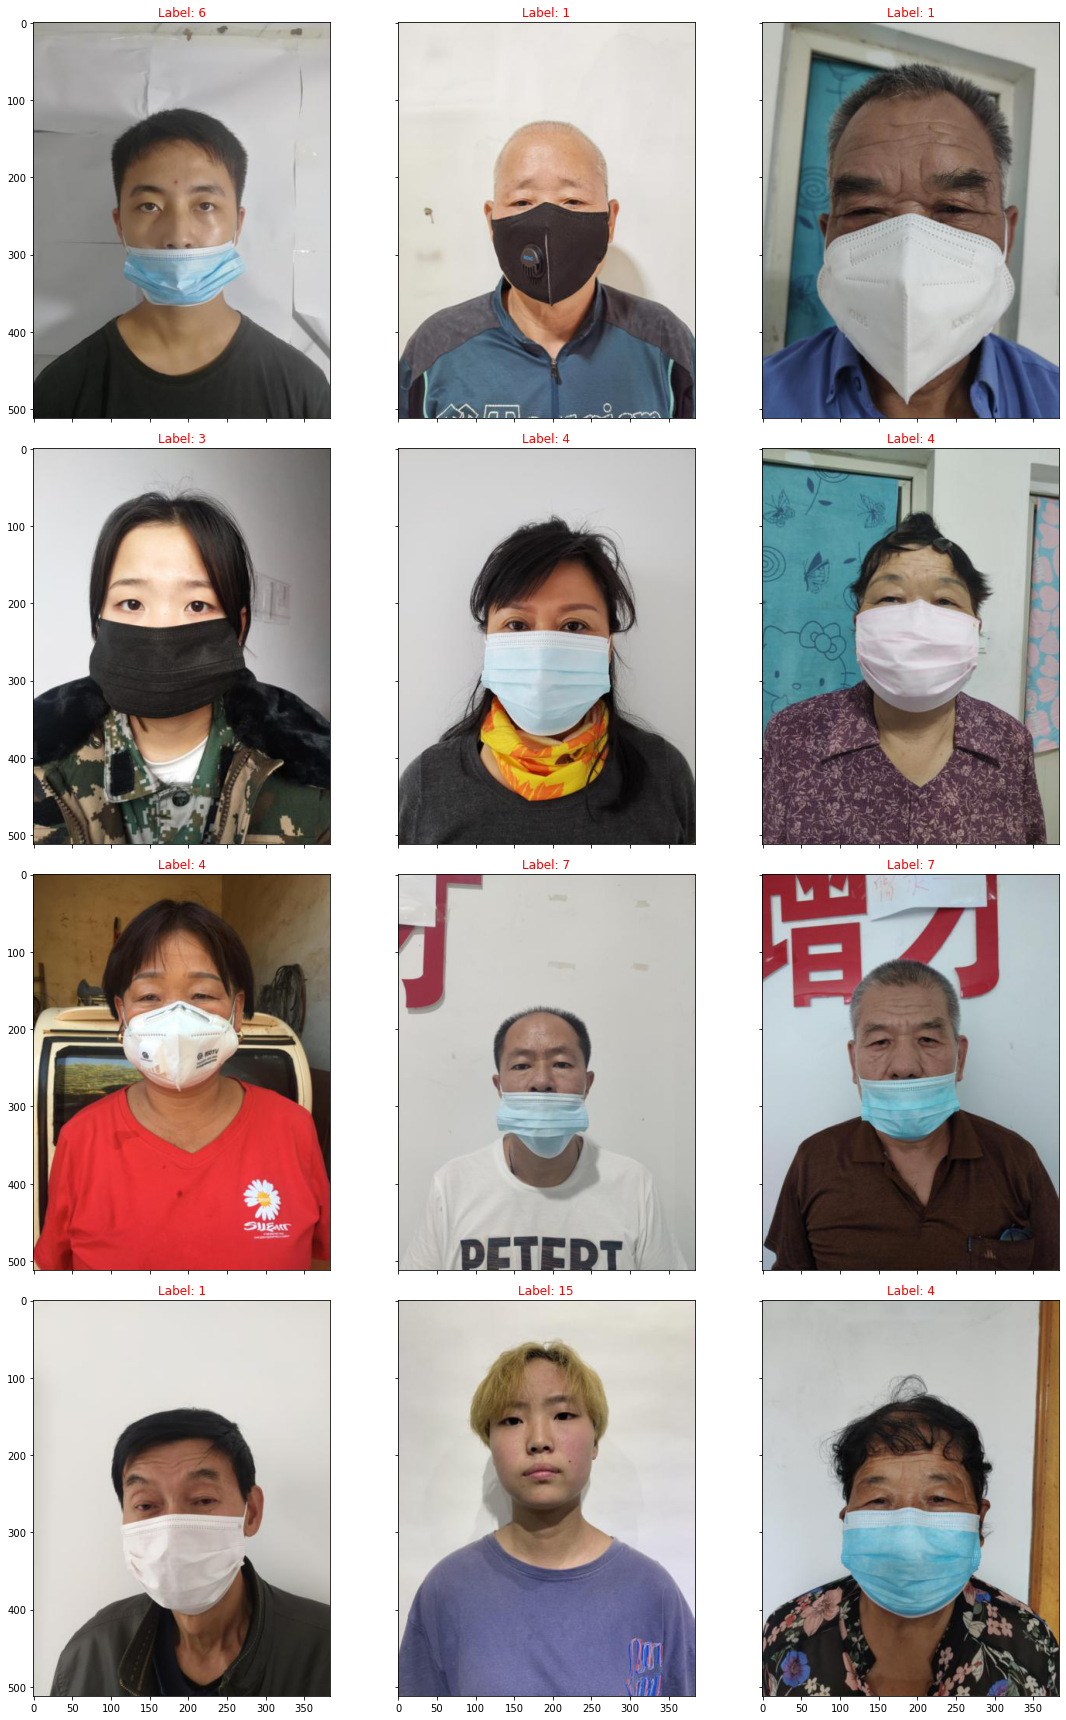

In [60]:
# Augmentation으로 이미지를 Normalize했기 때문에, 역으로 다시 Normalize 해주어야합니다.
# inv_normalize = transforms.Normalize(
#     mean=[-m / s for m, s in zip(mean, std)],
#     std=[1 / s for s in std]
# )

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols+1)].imshow(images[i].permute(1,2,0))
    axes[i%n_rows][i//(n_cols+1)].set_title(f'Label: {labels[i]}', color='r')
plt.tight_layout()

# 5. Define a Model

In [61]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [62]:
n_classes = 18
model.fc = nn.Linear(512, n_classes)

In [63]:
import torch.nn.init as init

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

In [64]:
# feature 파트만 freeze
# pretrained_model.features.requires_grad_(False)
for param, weight in model.named_parameters():
    print(f"파라미터 {param:20} 가 gradient 를 tracking 하나요? -> {weight.requires_grad}")

파라미터 conv1.weight         가 gradient 를 tracking 하나요? -> True
파라미터 bn1.weight           가 gradient 를 tracking 하나요? -> True
파라미터 bn1.bias             가 gradient 를 tracking 하나요? -> True
파라미터 layer1.0.conv1.weight 가 gradient 를 tracking 하나요? -> True
파라미터 layer1.0.bn1.weight  가 gradient 를 tracking 하나요? -> True
파라미터 layer1.0.bn1.bias    가 gradient 를 tracking 하나요? -> True
파라미터 layer1.0.conv2.weight 가 gradient 를 tracking 하나요? -> True
파라미터 layer1.0.bn2.weight  가 gradient 를 tracking 하나요? -> True
파라미터 layer1.0.bn2.bias    가 gradient 를 tracking 하나요? -> True
파라미터 layer1.1.conv1.weight 가 gradient 를 tracking 하나요? -> True
파라미터 layer1.1.bn1.weight  가 gradient 를 tracking 하나요? -> True
파라미터 layer1.1.bn1.bias    가 gradient 를 tracking 하나요? -> True
파라미터 layer1.1.conv2.weight 가 gradient 를 tracking 하나요? -> True
파라미터 layer1.1.bn2.weight  가 gradient 를 tracking 하나요? -> True
파라미터 layer1.1.bn2.bias    가 gradient 를 tracking 하나요? -> True
파라미터 layer2.0.conv1.weight 가 gradient 를 tracking 하나요? -> True
파라미터 layer2.0.bn1.w

In [65]:
initialize_weights(model.fc)

# Train the model

In [66]:
import copy
import time
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [67]:
model = model.to(device)

In [68]:
def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                print('training phase')
                model.train()
            else:
                print('validation phase')
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [70]:
model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 0/19
----------
training phase



train Loss: 0.5186 Acc: 0.8395
validation phase



val Loss: 0.4997 Acc: 0.8325

Epoch 1/19
----------
training phase



train Loss: 0.2306 Acc: 0.9193
validation phase



val Loss: 0.4416 Acc: 0.8517

Epoch 2/19
----------
training phase



train Loss: 0.1485 Acc: 0.9484
validation phase



val Loss: 0.4982 Acc: 0.8378

Epoch 3/19
----------
training phase



train Loss: 0.0946 Acc: 0.9694
validation phase



val Loss: 0.2239 Acc: 0.9207

Epoch 4/19
----------
training phase



train Loss: 0.0570 Acc: 0.9820
validation phase



val Loss: 0.1854 Acc: 0.9398

Epoch 5/19
----------
training phase



train Loss: 0.0574 Acc: 0.9810
validation phase



val Loss: 0.2969 Acc: 0.9213

Epoch 6/19
----------
training phase



train Loss: 0.0488 Acc: 0.9839
validation phase



val Loss: 0.1786 Acc: 0.9429

Epoch 7/19
----------
training phase



train Loss: 0.0411 Acc: 0.9867
validation phase



val Loss: 0.0938 Acc: 0.9706

Epoch 8/19
----------
training phase



train Loss: 0.0157 Acc: 0.9949
validation phase



val Loss: 0.1894 Acc: 0.9498

Epoch 9/19
----------
training phase



train Loss: 0.0533 Acc: 0.9818
validation phase



val Loss: 0.2381 Acc: 0.9229

Epoch 10/19
----------
training phase



train Loss: 0.0298 Acc: 0.9913
validation phase



val Loss: 0.1138 Acc: 0.9706

Epoch 11/19
----------
training phase



train Loss: 0.0205 Acc: 0.9940
validation phase



val Loss: 0.1743 Acc: 0.9504

Epoch 12/19
----------
training phase



train Loss: 0.0358 Acc: 0.9882
validation phase



val Loss: 0.1354 Acc: 0.9651

Epoch 13/19
----------
training phase



train Loss: 0.0166 Acc: 0.9947
validation phase



val Loss: 0.1505 Acc: 0.9595

Epoch 14/19
----------
training phase



train Loss: 0.0253 Acc: 0.9920
validation phase



val Loss: 0.1826 Acc: 0.9473

Epoch 15/19
----------
training phase



train Loss: 0.0393 Acc: 0.9875
validation phase



val Loss: 0.2449 Acc: 0.9268

Epoch 16/19
----------
training phase



train Loss: 0.0163 Acc: 0.9947
validation phase



val Loss: 0.1117 Acc: 0.9717

Epoch 17/19
----------
training phase



train Loss: 0.0087 Acc: 0.9974
validation phase



val Loss: 0.2048 Acc: 0.9498

Epoch 18/19
----------
training phase



train Loss: 0.0350 Acc: 0.9883
validation phase



val Loss: 0.2630 Acc: 0.9362

Epoch 19/19
----------
training phase



train Loss: 0.0358 Acc: 0.9881
validation phase



val Loss: 0.1332 Acc: 0.9631

Training complete in 58m 58s
Best val Acc: 0.971722
